# Tracking script

### Will be great to be it at a class
### Need to try it with real cells

In [1]:
%matplotlib inline

In [2]:
from math import *
import numpy as np
from skimage import io
from scipy.ndimage import gaussian_filter
import itertools as itt
import matplotlib.pyplot as plt
from skimage.filters import median
from skimage.morphology import disk

## Find Maxima (Center of mass)

In [3]:
def find_max(image, x):
    J = np.zeros(image.shape, dtype=bool)
    J[1:-1,1:-1,x] = ((image[1:-1,1:-1,x] > image[ :-2, :-2,x]) & (image[1:-1,1:-1,x] > image[ :-2, 1:-1,x]) & (image[1:-1,1:-1,x] > image[ :-2,2:,x]) &
                      (image[1:-1,1:-1,x] > image[1:-1, :-2,x]) &                                      (image[1:-1,1:-1,x] > image[1:-1,2:,x]) &
                      (image[1:-1,1:-1,x] > image[2:  , :-2,x]) & (image[1:-1,1:-1,x] > image[2:  , 1:-1,x]) & (image[1:-1,1:-1,x] > image[2:  ,2:,x]))
    
    J[1:-1,1:-1,(x-1)] = ((image[1:-1,1:-1,x] > image[ :-2, :-2,(x-1)]) & (image[1:-1,1:-1,x] > image[ :-2, 1:-1,(x-1)]) & (image[1:-1,1:-1,x] > image[ :-2,2:,(x-1)]) &
                      (image[1:-1,1:-1,x] > image[1:-1, :-2,(x-1)]) & (image[1:-1,1:-1,x] > image[1:-1, 1:-1,(x-1)]) & (image[1:-1,1:-1,x] > image[1:-1,2:,(x-1)]) &
                      (image[1:-1,1:-1,x] > image[2:  , :-2,(x-1)]) & (image[1:-1,1:-1,x] > image[2:  , 1:-1,(x-1)]) & (image[1:-1,1:-1,x] > image[2:  ,2:,(x-1)]))
    
    J[1:-1,1:-1,(x+1)] = ((image[1:-1,1:-1,x] > image[ :-2, :-2,(x+1)]) & (image[1:-1,1:-1,x] > image[ :-2, 1:-1,(x+1)]) & (image[1:-1,1:-1,x] > image[ :-2,2:,(x+1)]) &
                      (image[1:-1,1:-1,x] > image[1:-1, :-2,(x+1)]) & (image[1:-1,1:-1,x] > image[1:-1, 1:-1,(x+1)]) & (image[1:-1,1:-1,x] > image[1:-1,2:,(x+1)]) &
                      (image[1:-1,1:-1,x] > image[2:  , :-2,(x+1)]) & (image[1:-1,1:-1,x] > image[2:  , 1:-1,(x+1)]) & (image[1:-1,1:-1,x] > image[2:  ,2:,(x+1)]))
    
    return J[:,:,x] & J[:,:,x-1] & J[:,:,x+1]

In [4]:
def find_blob_DoG(image, thresh, dist):

    min_sigma=1
    max_sigma=100
    sigma_ratio=1.6

    k = int(log(float(max_sigma) / min_sigma, sigma_ratio)) + 1

        # a geometric progression of standard deviations for gaussian kernels
    sigma_list = np.array([min_sigma * (sigma_ratio ** i)for i in range(k + 1)])

    gaussian_images = [gaussian_filter(image, s) for s in sigma_list]

        # computing difference between two successive Gaussian blurred images
        # multiplying with standard deviation provides scale invariance
    dog_images = [(gaussian_images[i] - gaussian_images[i + 1])* sigma_list[i] for i in range(k)]
    image_cube = np.dstack(dog_images)

    maxima = []
    for n in range(1, 4):
        maxima.append(find_max(image_cube, n))
    arr = np.array(maxima)    


    arr &= image > thresh
    
    local_maxima = np.argwhere(np.bitwise_or.reduce(arr))
    add = np.zeros(local_maxima[:,0].shape)
    local_maxima = np.concatenate((local_maxima, add[:,np.newaxis]), axis=1).astype("int64")
    

    
    for blob1, blob2 in itt.combinations(local_maxima, 2):
        d = hypot(blob1[0] - blob2[0], blob1[1] - blob2[1])
        if d < dist :
            blob2[2] = -1
           
    
    return np.array([b for b in local_maxima if b[2] >= 0])

In [5]:
# Create liste of blob over the time laps 
def Num_Blob(data, nt, thresh=1.5, dist=5):
    list_blob = []
    for t in range(nt):
        blob = find_blob_DoG(data[t,:,:], thresh=thresh, dist=dist)
        list_blob.append(blob)

    return list_blob

In [6]:
img = io.imread("SwimmingAlgae.tif")

## Clean the time lapse

In [7]:
#Average of all the images in Time Lapse
img_average = np.mean(img, axis = 0).astype('uint8')
#Blur the average image
img_median = median(img_average, disk(20))

In [8]:
# Create a stack of divided images
nt, nx, ny = img.shape
img_divide = np.empty([nt,nx,ny])
for t in range(nt):
    img_divide[t,:,:] = np.divide(img[t,:,:], img_median)

In [9]:
def smooth_plot(image):
    x_no_smooth = np.linspace(0, len(image[0,50,:-1]),len(image[0,50,:-1]))
    x_smooth = np.linspace(0, len(image[0,50,:-2]), 100)
    y_smooth = spline(x_no_smooth, image[0,50,:-1], x_smooth)
    return(x_smooth, y_smooth)

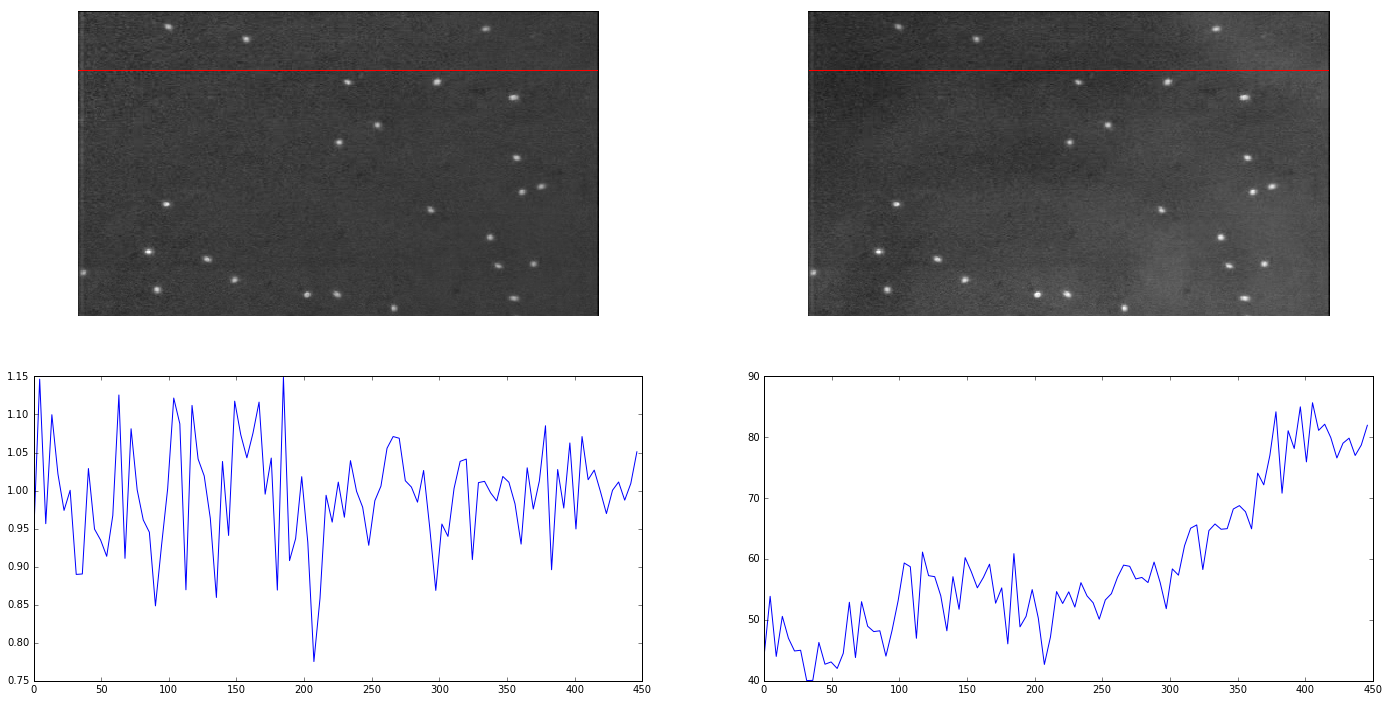

In [10]:
from scipy.interpolate import spline

fig, axes = plt.subplots(2,2, figsize=(24, 12))
x_smooth_divide, y_smooth_divide=smooth_plot(img_divide)
x_smooth, y_smooth=smooth_plot(img)

axes[0,0].imshow(img_divide[0,:,:], cmap="gray",interpolation='nearest')
axes[0,0].plot([0,len(img_divide[0,50,:-1])], [50, 50], 'k-', color='r')
axes[0,0].axis("off")
axes[0,0].autoscale_view('tight')
axes[1,0].plot(x_smooth_divide, y_smooth_divide)
axes[0,1].imshow(img[0,:,:], cmap="gray",interpolation='nearest')
axes[0,1].plot([0,len(img[0,50,:-1])], [50, 50], 'k-', color='r')
axes[0,1].axis("off")
axes[0,1].autoscale_view('tight')
axes[1,1].plot(x_smooth, y_smooth)

fig.savefig('flatten.png', bbox_inches='tight')

In [11]:
local_maxima = Num_Blob(img_divide, nt)

## Link the coordinate of maxima

In [12]:
# Building one Track base on distance

from scipy.spatial import distance

def Construct_Track(local_maxima, max_search = 4, max_dist = 7, particle = 0, nx = 0, tp=0):

    lst_fina=[]
    j = 0
    tp=tp
    # nx is the object to track
    
    l1 = local_maxima[nx][particle,0:2][np.newaxis, :]

    for l2 in local_maxima[1:]:
        
        # Find all the distances between l1 and every object in the +1 frame
        dist = distance.cdist(l1, l2[:,0:2], 'euclidean')      
        #Concatenate coordinate Time frame 1 and +1 if distance is < max      
        result =  np.concatenate((l2[:,0][dist[0]<max_dist], l2[:,1][dist[0]<max_dist]), axis=0)
        result_tp = np.concatenate((result, (np.full(1 ,tp, dtype=result.dtype))))
        
        #check, if during this loop I didn't find any close coordinate at T+1 for max_search above T
        if int(result.shape[0]) == 0:
            j+=1
            if j < max_search:
                continue
            else:
                break
        #if shape >2 (if I found more than 1 objecte within the max distance I stop the loop)
        elif int(result.shape[0]) > 2:
            break
        
        l1_tp = np.concatenate((l1, (np.full((1,1) ,tp, dtype=l1.dtype))), axis=1)
        lst_fina.append(np.vstack((l1_tp, result_tp)))
        
        #So I start the loop at T+1
        
        l1 = result[np.newaxis, :]
        
        tp+=1
    arr = np.asarray(lst_fina)
    return(arr[:,0,:])


In [13]:
# To track all cells in time frame (will looh after T0 as well)

def multiple_track_all(local_maxima, img, max_search = 4, max_dist = 7):
    liste_a=[]
    nt, nx, ny = img.shape
    
    # First I track every object present in the first frame and create a list
    for x in range(len(local_maxima[0])):
        try:
            Track = Construct_Track(local_maxima, max_search=max_search, max_dist=max_dist,particle = x)
        except IndexError:
            pass
   
        liste_a.append(Track)
    k=0
    # It will now continue to the next frame
    
    #First loop is too go through every time point
    
    for y in range(len(local_maxima)):
        k+=1
        #make sure I stop the loop before I am above the size of local_maxima
        if k >= len(local_maxima):
            break
            
        #2nd loop is to go through every object in the time frame
        for x in range(len(local_maxima[k])):
            liste_a_tup = [tuple(row) for row in np.vstack(liste_a)[:,0:2]]
            #Check if object is not in the list of coordinate already tracked to avoid duplicate

            if tuple(local_maxima[k][x,0:2]) not in liste_a_tup: 
                try:
                    Track2 = Construct_Track(local_maxima, max_search=max_search, max_dist=max_dist, 
                                             particle = x, nx = k, tp=y)
                    
                    if np.all(Track2[:,2] <= nt) and len(Track2) > 5:
                        liste_a.append(Track2)
                except IndexError:
                    pass
    return(liste_a)    

In [14]:
liste_a = multiple_track_all(local_maxima, img)

## Plot

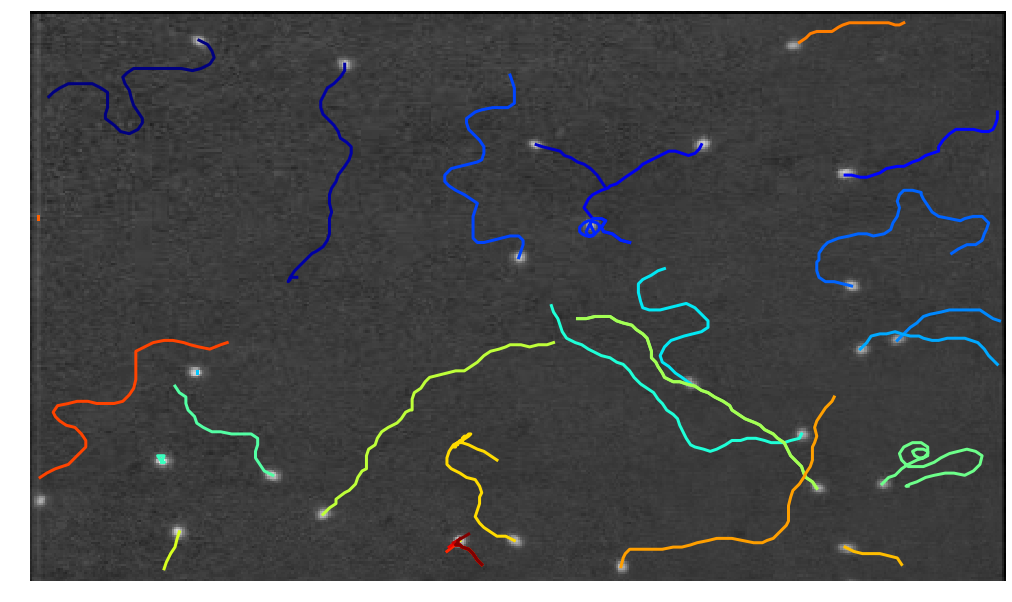

In [15]:

fig, axes = plt.subplots(1,1, figsize=(nx/15, ny/15))
axes.imshow(img_divide[0,:,:], cmap="gray",interpolation='nearest')

color=iter(plt.cm.jet(np.linspace(0,1,len(liste_a))))

for n in range(len(liste_a)):  
    c=next(color)
    axes.plot(liste_a[n][:,1], liste_a[n][:,0], linewidth=3, c=c)
axes.axis("off")
axes.autoscale_view('tight')

fig.savefig('Track_2D.png', bbox_inches='tight')

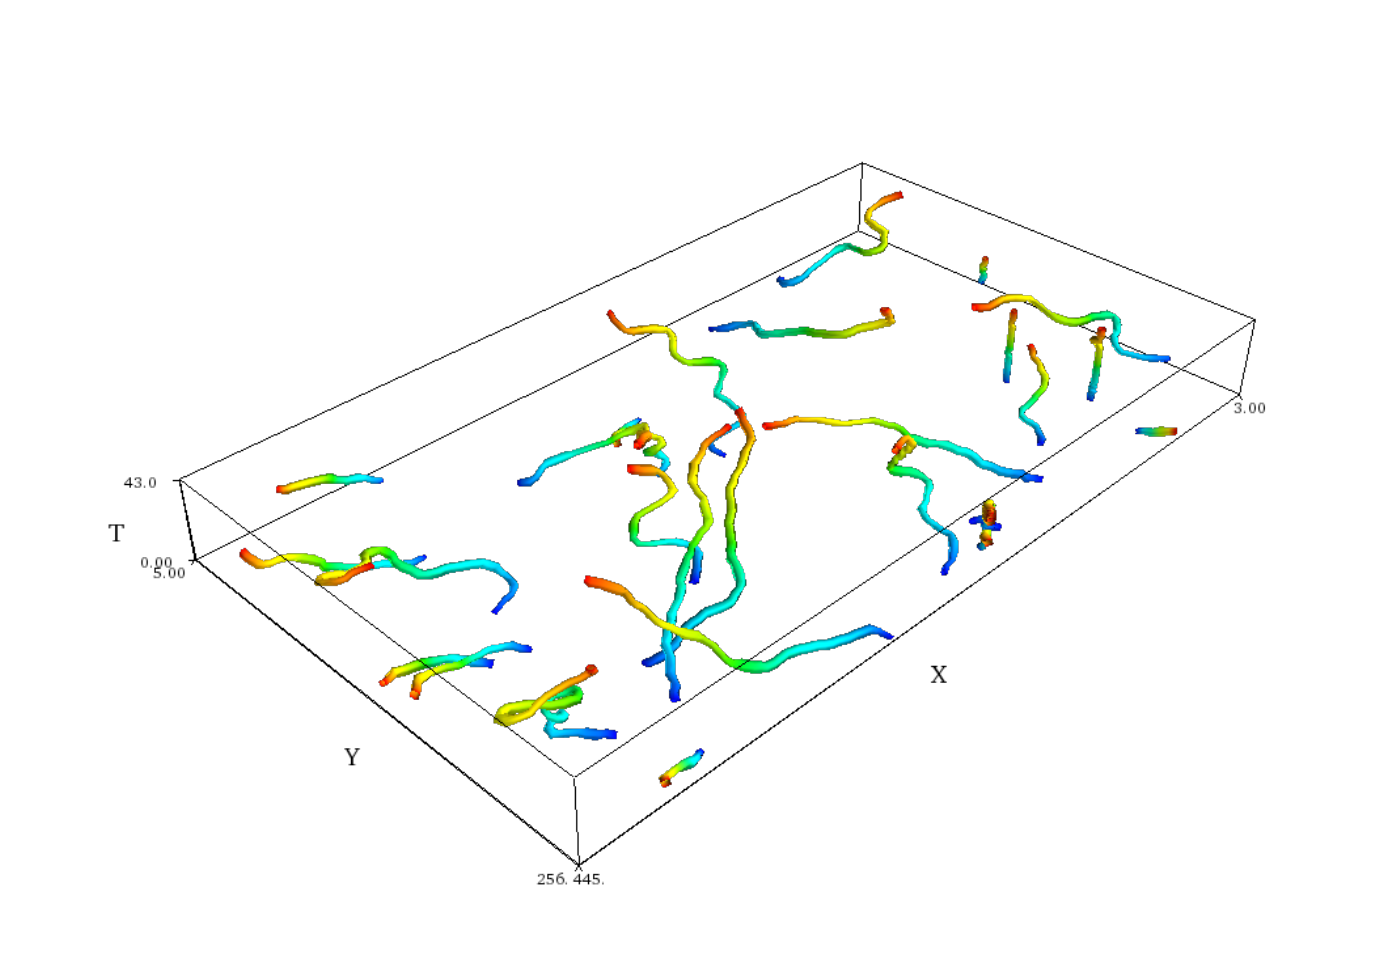

In [16]:
# Plot the track in 3D
from mayavi import mlab
scene = mlab.figure(size = (1024,768), fgcolor=(0, 0, 0), bgcolor=(0.8, 0.8, 0.8))

arr = np.concatenate(liste_a[:], axis=0)
x = arr[:,1]
y = arr[:,0]
z = arr[:,2]
ax = mlab.plot3d(x,y, z, tube_radius=0)
ax = mlab.axes(zlabel="T")
ax.title_text_property.bold = False
ax.label_text_property.bold = False
ax.title_text_property.italic = False
ax.label_text_property.italic = False
ax.title_text_property.font_family = "times"
ax.label_text_property.font_family = "times"
ax.axes.font_factor=1
mlab.outline()

for n in range(len(liste_a)):
    x = liste_a[n][:,1]
    y = liste_a[n][:,0]
    z = liste_a[n][:,2]
    t = np.linspace(0, 20, len(z))
    exp = mlab.plot3d(x,y, z, t, tube_radius=2)

scene.scene.camera.position = [723.11244587305441, 595.11034212703476, 474.40094467678716]
scene.scene.camera.focal_point = [250.2378683140945, 122.2357645680766, 1.5263671178281939]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.0, 0.0, 1.0]
scene.scene.camera.clipping_range = [384.60043576038015, 1367.8917952716088]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()

#mlab.show()

arr = mlab.screenshot(mode='rgba')
mlab.close(scene)

fig, axes = plt.subplots(figsize=(24,24))
axes.axis("off")
axes.autoscale_view('tight')
axes.imshow(arr)

fig.savefig('Track_3D.png', bbox_inches='tight')

In [17]:
import pandas as pd

In [18]:
name =[]
i=0
for n in range(len(local_maxima[0])):
    i+=1
    name.append("cell_{}".format(i))
print(name)

In [19]:
liste_dataframe =[]
for x in range(len(liste_a)):
    df = pd.DataFrame(liste_a[x], columns=["x", "y", "t"])
    liste_dataframe.append(df)
result = pd.concat(liste_dataframe,axis=0, keys=name) 

In [20]:
def compute_msd(trajectory, t_step, coords=['x', 'y']):
    
    delays = trajectory['t']
    shifts = np.floor(delays/t_step).astype(np.int)
    msds = np.zeros(shifts.size)
    for i, shift in enumerate(shifts):
        diffs = trajectory[coords] - trajectory[coords].shift(-shift)
        sqdist = np.square(diffs).sum(axis=1)
        msds[i] = np.trim_zeros(sqdist).mean()
    return delays, msds


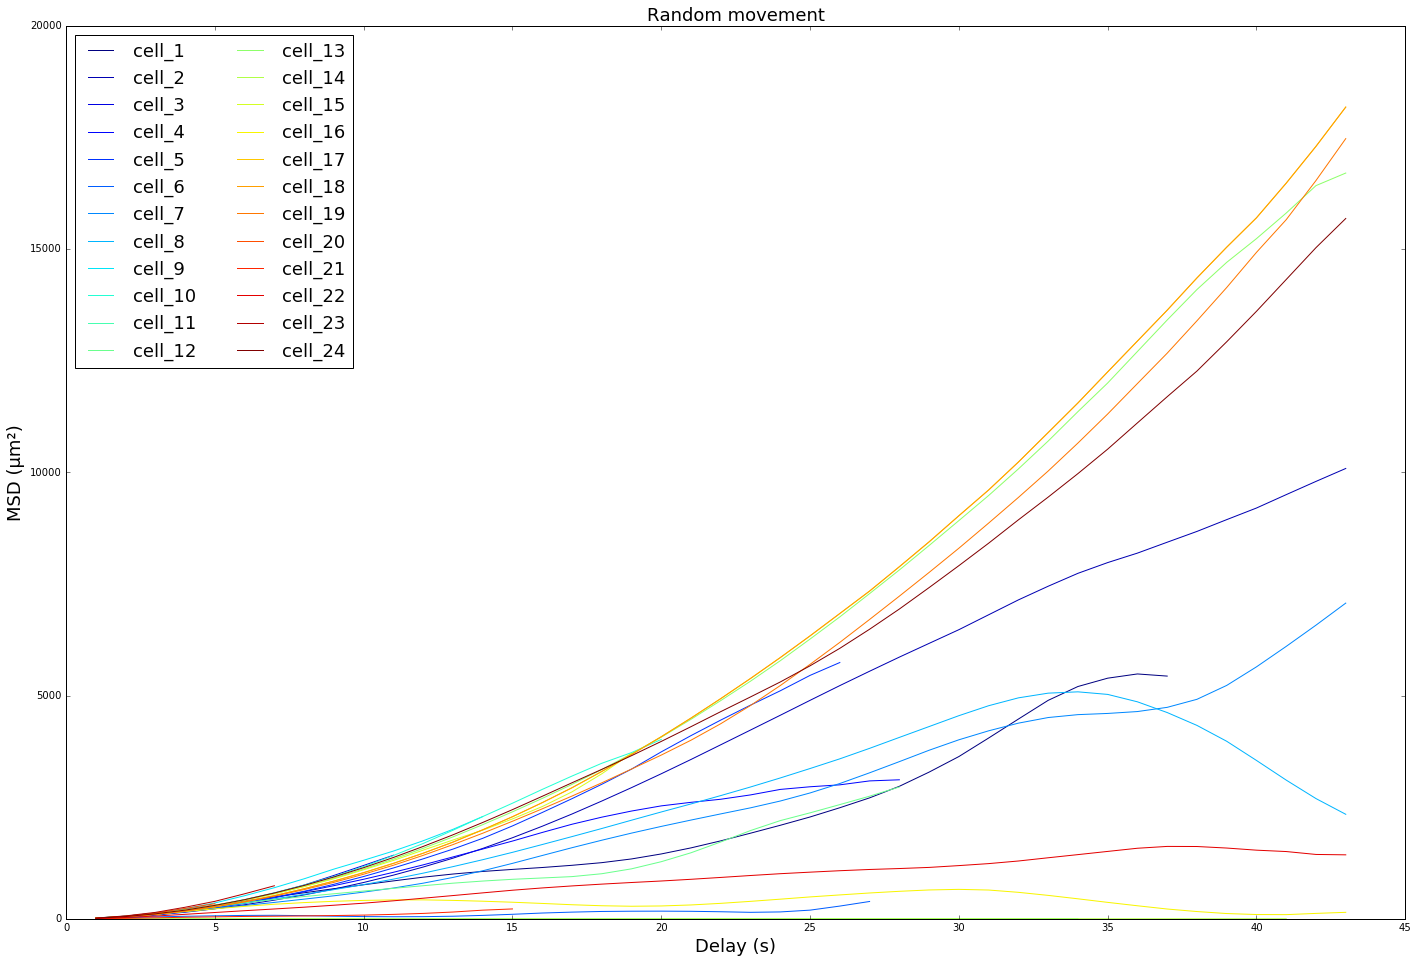

In [25]:
fig, (ax) = plt.subplots(1, 1, figsize=(24, 16))
color=iter(plt.cm.jet(np.linspace(0,1,len(result.groupby(level=0)))))

for cell, new_df in result.groupby(level=0):
    c=next(color)
    delays, msds = compute_msd(new_df, t_step=1)
    ax.plot(delays, msds, '-r',label=cell, c=c)
    ax.legend(loc=2, ncol=2, fontsize=18)
    ax.set_title("Random movement", fontsize=18)
    ax.set_xlabel('Delay (s)', fontsize=18)
    ax.set_ylabel('MSD (µm²)', fontsize=18)
    
fig.savefig('MSD.png', bbox_inches='tight')